# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 90.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=d02898ab9bc70f646ba23143d4980af2c11ec1978ae47543598fea970d3168f6
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=1fd62d7d9cfdda9e1ba1f2003126fc94b98d83a5a2f02fb3dc262a3492993be3
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c6

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 34.30 MiB/s, done.
Resolving deltas: 100% (3/3), done.


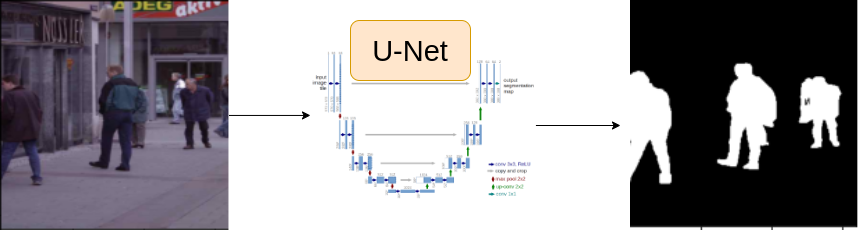

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE='/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR= '/content/'

DEVICE='cuda'
EPOCHS=25
LR=0.003
IMAGE_SIZE=320

ENCODER='timm-efficientnet-b0'
WEIGHTS='imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[4]
image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

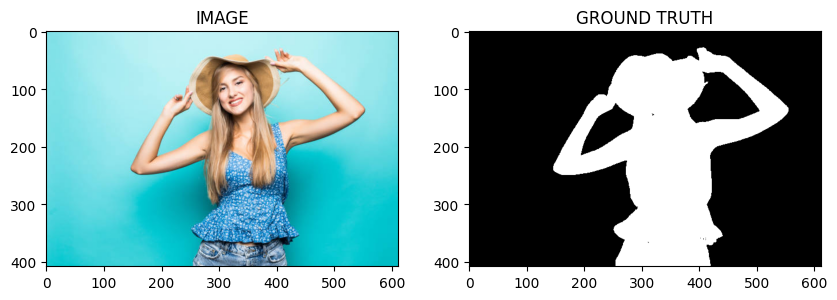

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(0.5),
      A.VerticalFlip(0.5)

  ],is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),

  ],is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    # need to expand dimension of mask to show grayscale image
    mask= np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

      # h,w,c => c,h,w
      image = np.transpose(image, (2,0,1)).astype(np.float32)
      mask = np.transpose(mask, (2,0,1)).astype(np.float32)

      image = torch.Tensor(image)/255.0
      mask = torch.round(torch.Tensor(mask)/255.0)
      return image,mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


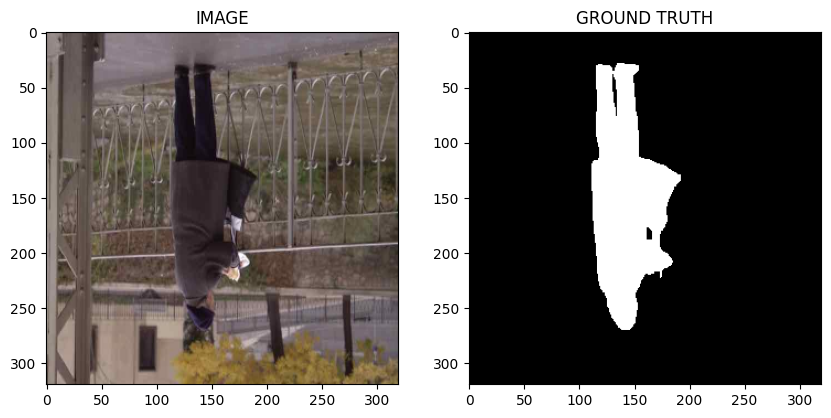

In [ ]:
idx=4
image,mask = trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=16, shuffle =True)
validloader = DataLoader(validset, batch_size=16)

In [ ]:
print(f'total number of train batch size ={len(trainloader)}')
print(f'total number of valid batch size ={len(validloader)}')

total number of train batch size =15
total number of valid batch size =4


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels=3,
        classes =1,
        activation=None
    )

  def forward(self, images, masks=None):
    logits = self.arc(images)
    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits,loss1+loss2

    return logits

In [ ]:
model=SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader, model,optimizer):
  model.train()
  total_loss = 0.0
  for images,masks in data_loader:
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model (images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss/len(data_loader)


In [ ]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images,masks in data_loader:
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      # optimizer.zero_grad()
      logits, loss = model (images, masks)
      # loss.backwards()
      # optimizer.step()

      total_loss += loss.item()

    return total_loss/len(data_loader)


# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model,optimizer )
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_models.pt')
    print('Model saved')
    best_valid_loss = valid_loss

    print(f'Epoch: {i+2} Train loss: {train_loss}  valid loss: {valid_loss}')

Model saved
Epoch: 2 Train loss: 0.3710803965727488  valid loss: 0.8062979876995087
Model saved
Epoch: 3 Train loss: 0.27890859444936117  valid loss: 0.6961552202701569
Model saved
Epoch: 4 Train loss: 0.24353137910366057  valid loss: 0.6459479853510857
Model saved
Epoch: 6 Train loss: 0.15504778623580934  valid loss: 0.5598645880818367
Model saved
Epoch: 18 Train loss: 0.08190272698799769  valid loss: 0.539515882730484


# Task 9 : Inference

In [ ]:
idx = 2
model.load_state_dict(torch.load('/content/best_models.pt') )
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask >.5) *1.0

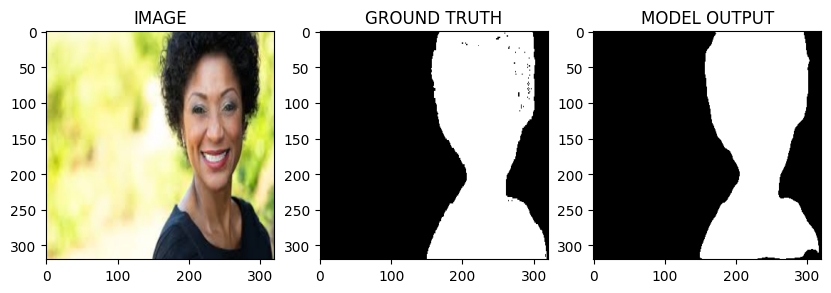

In [ ]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya